# Partner: Michelle Ho (Chia Chi Ho) 
# I'm in AC209a. My partner is in CS109A. We collaborated on the same notebook.

# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 2
# Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
import seaborn.apionly as sns
%matplotlib inline

/Users/jasminetong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Predicting Taxi Pickups in NYC

In this homework, we will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, we suggest that you normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

# Part (0): EDA

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

In [2]:
df_train = pd.read_csv('data/dataset_1_train.txt').sort_values('TimeMin')
df_train.head()
len(df_train)

250

In [3]:
df_test = pd.read_csv('data/dataset_1_test.txt').sort_values('TimeMin')
df_test.head()

,TimeMin,PickupCount
98,4.0,51.0
465,5.0,57.0
85,6.0,63.0
88,7.0,44.0
191,8.0,65.0


In [4]:
# Normalize TimeMin as suggested for both train and test data
df_train['TimeMin'] = df_train['TimeMin']/1440
df_test['TimeMin'] = df_test['TimeMin']/1440
df_train.head()

,TimeMin,PickupCount
36,0.002778,58.0
56,0.004861,16.0
1,0.011806,75.0
239,0.013194,61.0
10,0.027778,24.0


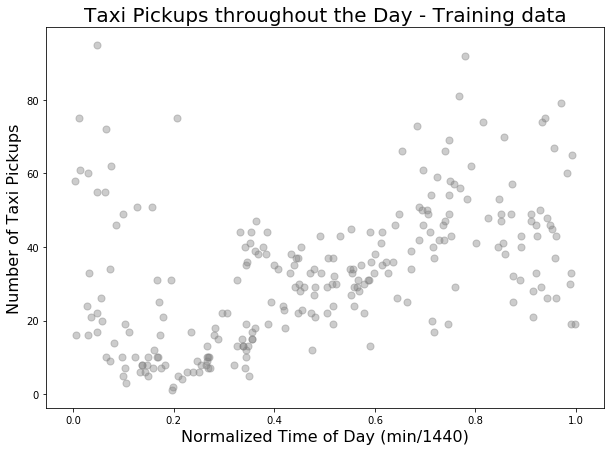

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.scatter(df_train['TimeMin'], df_train['PickupCount'], color='gray', alpha=0.4, s=50)

ax.set_title("Taxi Pickups throughout the Day - Training data", fontsize=20)
ax.set_xlabel("Normalized Time of Day (min/1440)", fontsize=16)
ax.set_ylabel("Number of Taxi Pickups", fontsize=16)

### Answer
<font color = "blue">
This makes intuitive sense as it matches a few trends: <br>
1. There are the least taxi pickups between 5am to 8am (~0.21-0.33 on the normalized axis) as most people have not gone to work and New York nightlife has died down. <br>
2. There is a small surge between 8am to 9am (~0.33-0.375 on the normalized axis) as some people choose to take the cab to work. It is only a small surge because presumably a lot of people take the subway to work. <br>
3. The number of pickups remain somewhat steady throughout the workday and greatly surges around 6pm (0.75 on the normalized axis) as people get off work and begin their night activities. <br>
4. The number of pickups can be the highest in later hours presumably because people tend not to take the subway late at night for either safety concerns or the slowing down of public transportation. <br>
</font>

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. You may use `sklearn`'s built-in functions to run k-NN regression. Create a `KNeighborsRegressor` object, use the `fit` method in the object to fit a k-NN regressor model, use the `predict` method to make predictions from the model, and the `score` method to evaluate the $R^2$ score of the model on a data set.

- Fit k-NN regression models:
    - Fit a k-NN regression model to the training set for different values of $k$ (e.g. you may try out values 1, 2, 10, 25, 50, 100 and 200). 
    - If you are using `sklearn`'s built-in functions for k-NN regression, explain what happens when you invoke the `fit` function. 
    - If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?
- Visualize the fitted models: 
    - Generate a scatter plot of the training data points, and in the same figure, also generate line plots of the predicted values $\hat{y}$ from each fitted model as a function of the predictor variable $x$. (*Hint:* you will want to sort the $x$ values before plotting.)
    - How does the value of $k$ effect the fitted model?
- Evaluate the fitted models:
    - Compute the $R^2$ score for the fitted models on both the training and test sets. Are some of the calculated $R^2$ values negative? If so, what does this indicate? What does a $R^2$ score of 0 mean?
    - Make plots of the training and test $R^2$ values as a function of $k$. Do the training and test $R^2$ plots exhibit different trends? Explain how the value of $k$ influences the training and test $R^2$ values.

In [6]:
# Load data for predictor X
x_train = df_train[['TimeMin']]
x_test = df_test[['TimeMin']]
# Load data for response Y
y_train = df_train.PickupCount
y_test = df_test.PickupCount

# Possible values for k
k_values = [1, 2, 10, 25, 50, 100, 200]

y_pred_train_list = []
y_pred_test_list = []

# Fit the k-NN model on each k
for k in k_values:
    knn_regr = KNeighborsRegressor(n_neighbors=k)
    # Train the model
    knn_regr.fit(x_train, y_train) 
    
    # Use trained model to make predictions for train and test datasets
    y_pred_train_list.append(knn_regr.predict(x_train)) 
    y_pred_test_list.append(knn_regr.predict(x_test))


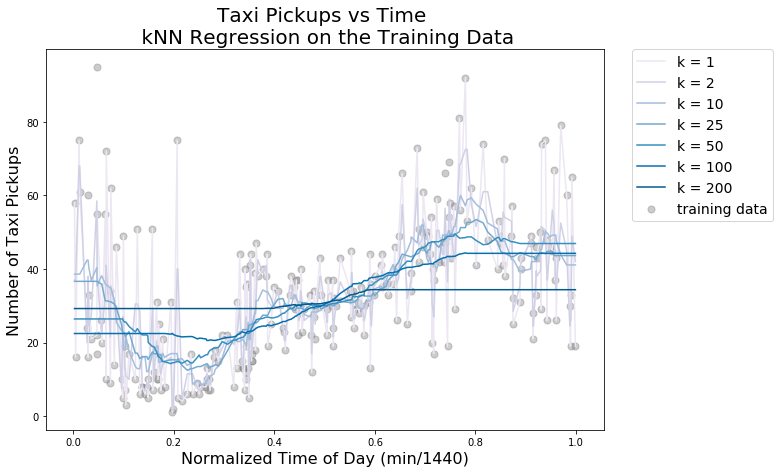

In [7]:
# Plot the raw data points and models for k = 1, 2, 10, 25, 50, 100, 200
ax1_palette = sns.set_palette(sns.color_palette("PuBu", 7))
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))

ax1.scatter(x_train, y_train, color='gray', alpha=0.4, s=50, label='training data')

for predictions, k_value in zip(y_pred_train_list, k_values):
    ax1.plot(x_train, predictions, label='k = %i' %k_value, color=ax1_palette)

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
ax1.set_title("Taxi Pickups vs Time \n kNN Regression on the Training Data", fontsize=20)
ax1.set_xlabel("Normalized Time of Day (min/1440)", fontsize=16)
ax1.set_ylabel("Number of Taxi Pickups", fontsize=16)

### Answer
<font color='blue'>
    <p>As we call `fit()` on a k-NN model, the model determines the neighbor boundaries for the predictions based on the training data and the `k` value. 
    </p>
    <p>The value of k can be any integer within `[1, num_observations]`. A model with k=n is inflexible, with low variance and high bias. The predictions from this model would be the same for any new inputs, which is the global mean of the training data.
    </p>
    <p>As `k` grows, the model variance decreases and becomes flatter with high bias.
    </p>
</font>

In [8]:
# Calculate R^2 for each k
r2_train = []
r2_test = []

for i in range(len(k_values)):
    r2_train.append(r2_score(y_train, y_pred_train_list[i]))
    r2_test.append(r2_score(y_test, y_pred_test_list[i]))

print('R2 scores on training data for k=1, 2, 10, 25, 50, 100, 200:')
print(r2_train)
print()

print('R2 scores on test data for k=1, 2, 10, 25, 50, 100, 200:')
print(r2_test)

R2 scores on training data for k=1, 2, 10, 25, 50, 100, 200:
[0.87897968282704175, 0.6468303480681783, 0.45097913477660767, 0.41921422595176028, 0.35433154580544879, 0.2869537997976257, 0.10857334021016818]

R2 scores on test data for k=1, 2, 10, 25, 50, 100, 200:
[0.026793114990582345, 0.23541124628516041, 0.41540664874257371, 0.41403032612599566, 0.38050111639302864, 0.31163937860854973, 0.10946504335780693]


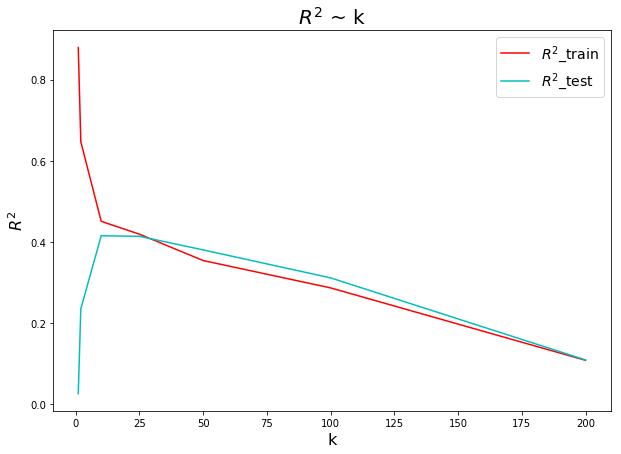

In [9]:
# Plot R^2 vs. k
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 7))

ax2.plot(k_values, r2_train, 'r-', label='$R^2$_train')
ax2.plot(k_values, r2_test, 'c-', label='$R^2$_test')
ax2.set_title('$R^2$ ~ k', fontsize=20)
ax2.set_xlabel('k', fontsize=16)
ax2.set_ylabel('$R^2$', fontsize=16)
ax2.legend(fontsize=14)

### Answer
<font color='blue'>
    <p> Based on our experiments and the graph above, the $R^2$ scores for all k-NN models are within [0, 1]. None of them are negative. Negative $R^2$ indicates the model does not predict the trend of the data. An $R^2$ score of 0 would occur when `k=num_observations`, meaning the model predicts $\bar{Y_{train}}$ for any input $X$. 
    </p>
    <p> The training and test $R^2$ plots exhibit different trends: $R_{train}^2$ monotonically decreases as `k` grows; $R_{test}^2$ increases for `k<=10` and begins to decline for greater k values. The two curves intersect near `k=25`. The value of k determines whether the model under- or over-fits while the comparison of $R^2$ between the training and the test set is an indicator of an under- or over-fit model. From out $R^2$ plot, when k is small, $R_{train}^2$ is greater than $R_{test}^2$ and is decreasing from 1 while $R_{test}^2$ is increasing from 0, this indicates that the model overfits. On the other hand, when k is large, $R_{test}^2>R_{train}^2$, and both decreasing, this indicates that the model underfits. The optimal value of `k` is found at the intersection of the two trends.
    </p>
</font>

# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Briefly explain your answer.

- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

In [10]:
# Add a column of ones to x_train for the intercept
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

# Build the OLS model (ordinary least squares) from the training data
simpleLinear_model = sm.OLS(y_train, X_train)
results_simpleLinear = simpleLinear_model.fit()

# Get beta parameters out from results_sm
beta0_simpleLinear = results_simpleLinear.params[0] # intercept
beta1_simpleLinear = results_simpleLinear.params[1] # slope

print('Summary of the regression fit: ', results_simpleLinear.summary)
print('intercept - const = %f' % beta0_simpleLinear)
print('slope - TimeMin = %f' % beta1_simpleLinear)


y_pred_train_simpleLinear = results_simpleLinear.predict(X_train)
y_pred_test_simpleLinear = results_simpleLinear.predict(X_test)

r2_train_simpleLinear = r2_score(y_train, y_pred_train_simpleLinear)
r2_test_simpleLinear = r2_score(y_test, y_pred_test_simpleLinear)

print('R2 score on train set: ', r2_train_simpleLinear)
print('R2 score on test set: ', r2_test_simpleLinear)

Summary of the regression fit:  <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x112e364e0>>
intercept - const = 18.026385
slope - TimeMin = 30.289023
R2 score on train set:  0.207213752099
R2 score on test set:  0.247712329948


### Answer
<font color='blue'>
    <p> The peculiar thing is that $R^2{train}$ is smaller than $R^2{test}$ for this regression.
    </p>
    <p> The $R^2{test}$ of linear regression (0.2477) is smaller than the best test $R^2{test}$ of k-NN (0.4154)
    </p>
    <p> The sign of slope is positive, which means that the number of Pickups increases as time progresses in a day.
    </p>
</font>

In [11]:
print('95% Confidence interval for the slope and intercept:')
print(results_simpleLinear.conf_int(alpha=0.05))

95% Confidence interval for the slope and intercept:
                 0          1
const    13.849865  22.202906
TimeMin  22.879319  37.698727


### Answer
<font color='blue'>
    <p> Both the 95% confidence intervals of the slope and the intercept are relatively large. Therefore, they are not reliable model parameters.
    </p>
    <p> We expect a 99% confidence interval of the slope and the intercept to be looser. By definition, a 95% confidence interval captures the true value 95% of the time. To increase this confidence to 99%, we need to increase the range of the interval. 
    </p>
</font>

In [12]:
print('99% Confidence interval for the slope and intercept:')
print(results_simpleLinear.conf_int(alpha=0.01))

99% Confidence interval for the slope and intercept:
                 0          1
const    12.521948  23.530822
TimeMin  20.523418  40.054628


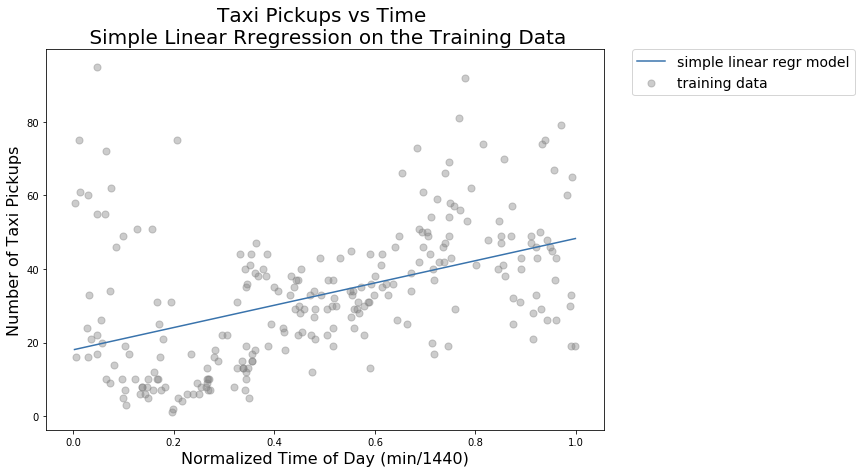

In [13]:
# Plot the regression line
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 7))

ax4.scatter(x_train, y_train, color='gray', alpha=0.4, s=50, label='training data')
ax4.plot(x_train, y_pred_train_simpleLinear, color='#3973ac', label='simple linear regr model')

ax4.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
ax4.set_title("Taxi Pickups vs Time \n Simple Linear Rregression on the Training Data", fontsize=20)
ax4.set_xlabel("Normalized Time of Day (min/1440)", fontsize=16)
ax4.set_ylabel("Number of Taxi Pickups", fontsize=16)

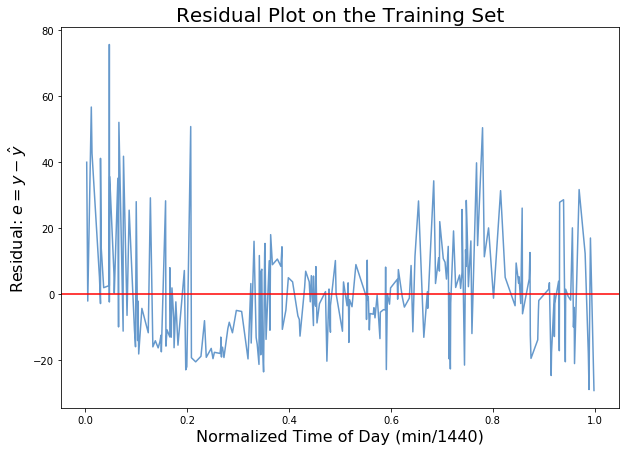

In [14]:
# Calculate the residual
e = y_train - y_pred_train_simpleLinear

# Plot the residual
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 7))

ax3.plot(x_train, e, '#6699cc')
plt.axhline(y = 0, color='r', linestyle='-')
plt.title('Residual Plot on the Training Set', fontsize=20)
plt.xlabel('Normalized Time of Day (min/1440)', fontsize=16)
plt.ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)

### Answer
<font color='blue'>
    <p> Based on the residual plot above, the residual does not equally fluctuate around 0. Therefore, the assumption of linearity of data is not valid. 
    </p>
</font>

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

### Answer
<font color='blue'>
    <p>By visual inspection, we think a polynomial of degree 3 would best fit the data.</p>
</font>

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, what difficulties in implementing polynomial regression may have occurred?

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ value? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (a)?

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

### Answer
<font color='blue'>
    <p>Had the time predictors not been normalized, the range of their values would be very large. However, the response variable has a much smaller range in comparison.  Thus, the coefficients of the polynomial would be very small, which could be rounded to 0 because of the limits of machine precision.</p>
</font>

In [15]:
degrees = [2, 3, 10, 25, 50, 100]

X_train_with_poly = []
X_test_with_poly = []

# Generate X_train and X_test matrices with polynomial terms
for d in degrees:
    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_train_with_poly.append(gen_poly_terms.fit_transform(x_train))
    X_test_with_poly.append(gen_poly_terms.fit_transform(x_test))

In [16]:
# Generate models of degrees 2, 3, 10, 25, 50 and make predictions using these models
results_polyRegr = []
y_pred_train_polyRegr = []
y_pred_test_polyRegr = []

for i in range(len(degrees)):
    poly_regression_model = sm.OLS(y_train, X_train_with_poly[i])
    
    poly_regression_fit = poly_regression_model.fit()
    results_polyRegr.append(poly_regression_fit)
    
    y_pred_train_polyRegr.append(poly_regression_fit.predict(X_train_with_poly[i]))
    y_pred_test_polyRegr.append(poly_regression_fit.predict(X_test_with_poly[i]))

In [17]:
# Print params for all poly regressions
#for i, d in enumerate(degrees):
#    print('Polynormial regression params with degree %i:' %d)
#    print(results_polyRegr[i].params)
#    print('--------------------------\n')

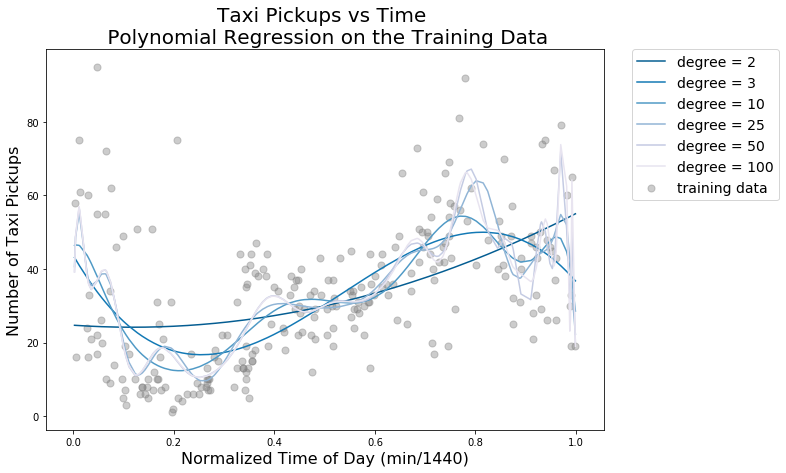

In [18]:
# Plot the regression line
ax4_palette = sns.set_palette(sns.color_palette("PuBu_r", len(degrees)))
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 7))

ax4.scatter(x_train, y_train, color='gray', alpha=0.4, s=50, label='training data')

for predictions, degree in zip(y_pred_train_polyRegr, degrees):
    ax4.plot(x_train, predictions, label='degree = %i' %degree, color=ax4_palette)

ax4.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
ax4.set_title("Taxi Pickups vs Time \n Polynomial Regression on the Training Data", fontsize=20)
ax4.set_xlabel("Normalized Time of Day (min/1440)", fontsize=16)
ax4.set_ylabel("Number of Taxi Pickups", fontsize=16)


In [19]:
# Evaluate R^2
r2_train_polyRegr = []
r2_test_polyRegr = []

for i, d in enumerate(degrees):   
    r2_train_i = r2_score(y_train, y_pred_train_polyRegr[i])
    r2_test_i = r2_score(y_test, y_pred_test_polyRegr[i])
    print('R2 score with degree %i:' %d)
    print('On the training set = ', r2_train_i)
    print('On the test set = ', r2_test_i)
    print('--------------------------')
    r2_train_polyRegr.append(r2_train_i)
    r2_test_polyRegr.append(r2_test_i)

R2 score with degree 2:
On the training set =  0.232433271029
On the test set =  0.255724142162
--------------------------
R2 score with degree 3:
On the training set =  0.374836239118
On the test set =  0.378584362248
--------------------------
R2 score with degree 10:
On the training set =  0.428277068624
On the test set =  0.402007800698
--------------------------
R2 score with degree 25:
On the training set =  0.463282425035
On the test set =  0.383629990432
--------------------------
R2 score with degree 50:
On the training set =  0.489154048124
On the test set =  0.33316090981
--------------------------
R2 score with degree 100:
On the training set =  0.502285375642
On the test set =  0.16143269304
--------------------------


### Answer
<font color='blue'>
    <p> A higher training $R^2$ does not necessarily indicate a high test $R^2$. $R^2$ scores of all different degrees of polynomial regressions are bigger than the $R^2$ of the simple linear regression but smaller than the best $R^2$ of k-NN. 
    </p>
</font>

In [20]:
# Caclulate residuals on training data
e_polyRegr = []

for i in range(len(degrees)):
    e_polyRegr.append(y_train - y_pred_train_polyRegr[i])

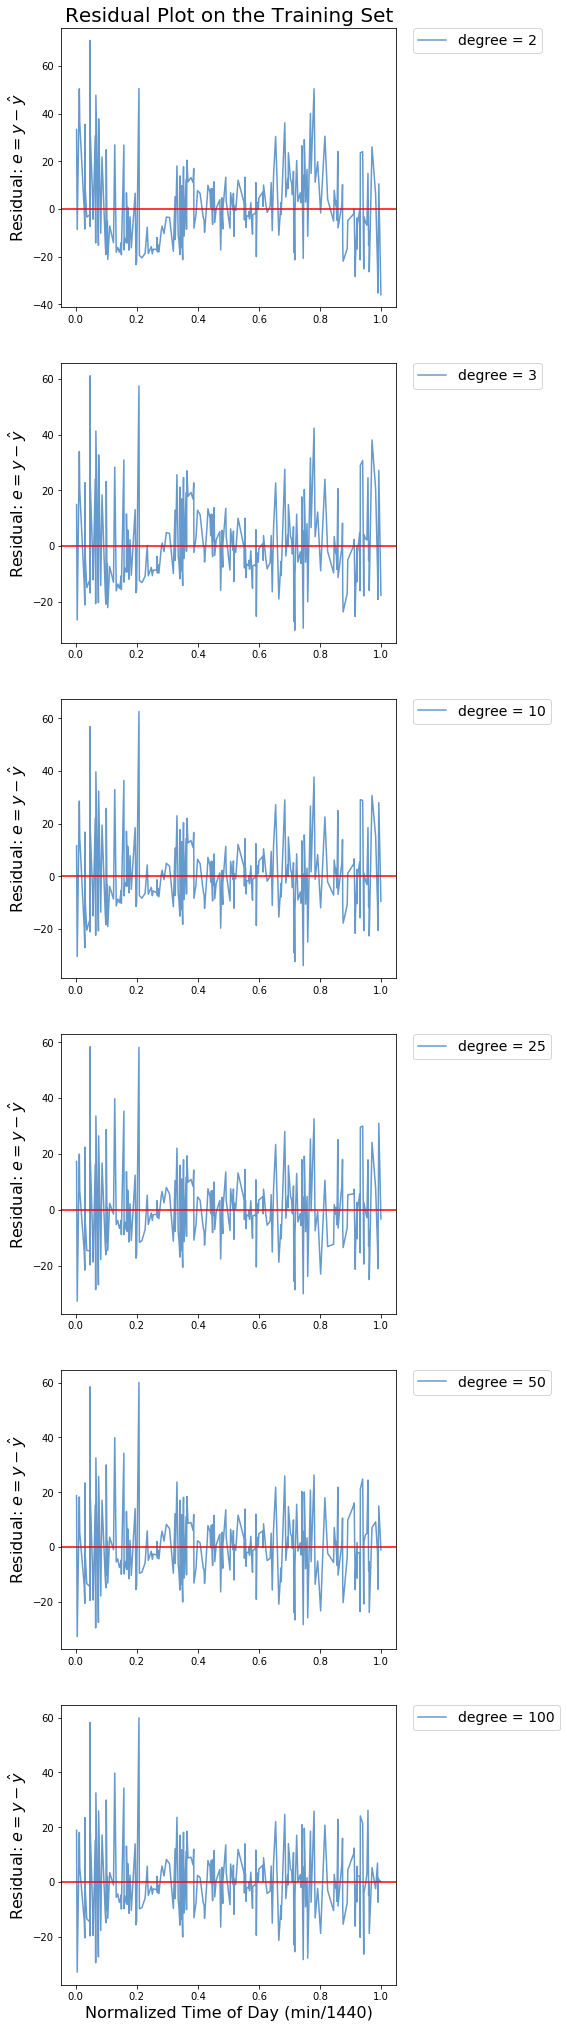

In [21]:
fig5, axs5 = plt.subplots(len(degrees),1, figsize=(len(degrees), len(degrees)*len(degrees)), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2, wspace=2)

for ax, e, d in zip(axs5.ravel(), e_polyRegr, degrees):
    ax.plot(x_train, e,'#6699cc',label='degree = %i' %d)
    ax.axhline(y = 0, color='r', linestyle='-')
    ax.set_ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)

axs5[0].set_title('Residual Plot on the Training Set', fontsize=20)
axs5[len(degrees)-1].set_xlabel('Normalized Time of Day (min/1440)', fontsize=16)


### Answer
<font color='blue'>
    As the polynomial degree increases, the residuals decrease and are more uniformly distributed around 0.
</font>

# Part (d): Summarize Results
In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day.  Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups?  How would you improve this model even further?  Feel free to refer to visual(s) above or provide a new one to make your case.



### Answer
<font color ='blue'><p>We would choose to predict the number of taxi cab pick-ups at any specific time of day using the kNN model with k = 10. This is because kNN with k = 10 is the model with the best $R^2$ of 0.4154 compared to the kNN models with other k values and to both simple linear and all of the polynomial regression models we tested. Unlike linear regression, kNN regression is a non-parametric method which does not assume we know the underlying distribution of the data, which allows it to more effectively and accurately model the subtle trends of normal human activity. Since kNN is a non-parametric model, there is no confidence intervals. As stated above, the model predicts with an $R^2$ value of 0.4154. One way to improve the model is to collect more observations, and we would expect the model performance ($R^2$, MSE) to improve.</p></font>

---- 


# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

### Question 1
Consider a space in $\mathbb{R}^5$, with two subspaces $S_0 \subset \mathbb{R}^5$ and $S_1 \subset \mathbb{R}^5$. For simplicity, let us consider the case where the subspace $S_0$ is spanned by the vectors $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ and the subspace $S_1$ is spanned by the vectors $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$. 

Now let us assume that we have a dataset that consists of labeled vectors in subspaces $S_0$ and $S_1$ respectively. Our task here is to use the data in the training dataset to classify an unknown vector into either $S_0$ or $S_1$.

Let us consider the case where we construct a predictive matrix $\mathbf{X}$ from the 'training' data for which we know the labels (note: is not meant to match $S_0$ and $S_1$ above).

```
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
```

(Briefly notice that the training data probably doesn't consist of vectors that are orthonormal in spanning $S_0$ or $S_1$).

And we have an unknown vector, for which we want clasify as either a noisy example of a vector in either $S_0$ or $S_1$: ```y_0 = np.array([2,10,1,0,0])```.

In [22]:
# starter code
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
y_0 = np.array([2,10,1,0,0])

#### Question 1a
Recall the solution for the Least Squares problem and the 'hat' matrix $\mathbf{H}$. Consider the case when $Y$ lies in the same subspace as the columns of $\mathbf{X}$. In this case, how accurate should the prediction of $\hat{Y}$ be?

#### Question 1b
Given the projection of $Y$ onto the space spanned by the columns of the X matrix. We can analyse the significance of the different predictor vectors (i.e. the building blocks that are used to reconstrct the $\hat{Y}$ vector). Discuss how this may help one when analysing a classification decision by the model.

#### Question 1c
As discussed in the linked paper, we have data that has vectors that are classified into one subspace or another (our training dataset). We can use the projection interpretation of linear regression to make a classification decision of a new (unseen) vector into either $S_0$ or $S_1$. In other words, construct X matrices from the known vectors, and project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. To do classification, we can calculate the minimum euclidean distance ($L_2$ norm) between the original vector and the projection. Use this method to classify ```y_0``` as belonging to either $S_0$ or $S_1$.

**Feel free to run this same example on the face data presented in the paper - you will be doing this for next week's homework regardless**

#### Question 1d (unrelated to the parts above)

Explicitly derive the relationship between the F-statistic (from the usual F test) and the $R^2$ measure in multiple linear regression (i.e. write the F-statistic of a multiple linear regression model in terms of the $R^2$ of the same model).

### Answer 1a
<font color='blue'>
The solution for the Least Squares problem ($\hat{Y}$) can be thought of as the orthogonal projection of $Y$ onto the space spanned by the columns of $\textbf{X}$. Therefore, if $Y$ lies in the same subspace as the columns of $\textbf{X}$, we can solve the systems of equations to get a unique set of the coefficients of $\textbf{X}$'s columns, hence prediction $\hat{Y}$ could exactly reconstruct $Y$.  
</font>

### Answer 1b
<font color='blue'>
In the paper, each subspace ($\textbf{X}_1$, $\textbf{X}_2$, ..., $\textbf{X}_N$) represents a class. By projecting $Y$ onto all subspaces, we get $\hat{Y}_1$, $\hat{Y}_2$, ...,  $\hat{Y}_N$. $Y$ is classified as belonging to class $\textbf{i}$ if it has a minimum distance (irreducible error) to the subspace $\textbf{X}_i$. $d_i(Y)$ is the smallest for any $d_j(Y)$ where $j=1,2,...N$. 

$\textbf{X}_i$'s column vectors make a set of significant predictor vectors compared to other subspaces' column vectors. A classification decision is made when there is one $d_i(Y)$ that is a significantly smaller than any other $d_j(Y)$ where $j \neq i$. 
</font>

### Answer 1c
<font color='blue'>
Using $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ to represent $S_0 \subset \mathbb{R}^5$ and $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$ to represent $S_1 \subset \mathbb{R}^5$ 

\begin{equation}
X_0 = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 0 \\
0 & 0 \\
0 & 0
\end{bmatrix}, \quad
X_1 = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1
\end{bmatrix}
\end{equation} <br>

We can calculate 
$\hat\beta_0 = (\textbf{X}^T_0\textbf{X}_0)^{-1}\textbf{X}^T_0\textbf{y}$ 
and
$\hat\beta_1 = (\textbf{X}^T_1\textbf{X}_1)^{-1}\textbf{X}^T_1\textbf{y}$ <br>

\begin{equation}
\hat\beta_0 = \begin{bmatrix}
2 \\
10
\end{bmatrix}, \quad
\hat\beta_1 = \begin{bmatrix}
0 \\
0
\end{bmatrix}
\end{equation} <br>

\begin{equation}
\hat{Y}_0 = [2,10,0,0,0]^T ,\quad
\hat{Y}_1 = [0,0,0,0,0]^T
\end{equation}<br>

\begin{equation}
y_0 = [2,10,1,0,0]^T
\end{equation}<br>

\begin{equation}
d_0(Y) = ||y_0-\hat{Y}_0||_2 = 1 ,\quad
d_1(Y) = ||y_0-\hat{Y}_1||_2 = \sqrt{105}
\end{equation}<br>

Since $d_0(Y) < d_1(Y)$, $y_0 = [2,10,1,0,0]^T$ should belongs to $S_0$.
</font>

In [23]:
# Coding for Question 1c
from numpy.linalg import inv
X0 = np.array([[1, 0],
               [0, 1],
               [0, 0],
               [0, 0],
               [0, 0]
              ])
X1 = np.array([[0, 0],
               [0, 0],
               [0, 0],
               [1, 0],
               [0, 1]
              ])

X0T = X0.transpose()
X1T = X1.transpose()

beta0 = np.dot(np.dot(inv(np.dot(X0T, X0)), X0T), y_0)
beta1 = np.dot(np.dot(inv(np.dot(X1T, X1)), X1T), y_0)

Y0_hat = np.dot(X0, beta0)
Y1_hat = np.dot(X1, beta1)

print('Y0_hat: ', Y0_hat)
print('Y1_hat: ', Y1_hat)

d0 = np.sum(np.square(y_0-Y0_hat))
d1 = np.sum(np.square(y_0-Y1_hat))

print('d0(Y): ', d0)
print('d1(Y): ', d1)

Y0_hat:  [  2.  10.   0.   0.   0.]
Y1_hat:  [ 0.  0.  0.  0.  0.]
d0(Y):  1.0
d1(Y):  105.0


### Answer 1d
<font color='blue'>

By definition, </font>
$\color{blue}{R^2 = 1 - \frac{RSS}{TSS} \text{ and } F = \frac{(TSS-RSS)/J}{RSS/(n-J-1)} \text{ where } J = \text{# of predictors and } n = \text{# of observations.}}$ 


<font color='blue'>Therefore, we have</font>
<br><br>

$\color{blue}{\begin{aligned}
    F &= \frac{(TSS-RSS)/J}{RSS/(n-J-1)}\\
    F &= \frac{(TSS-RSS)}{RSS} \cdot \frac{(n-J-1)}{J} \cdot \frac{TSS}{TSS} \hspace{12pt} \text{(multiply the RLS by 1)}\\
    F &= \frac{(TSS-RSS)}{TSS} \cdot \frac{TSS}{RSS} \cdot \frac{(n-J-1)}{J}\\
    \frac{F \cdot J}{(n-J-1)}&= R^2 \cdot \frac{TSS}{RSS} \\
    \frac{F \cdot J}{(n-J-1)} \cdot \frac{1}{R^2} &= \frac{TSS}{RSS} \\
    \frac{(n-J-1)}{F \cdot J} \cdot \frac{R^2}{1} &= \frac{RSS}{TSS} \hspace{12pt} \text{(invert both sides)}\\
    1 - \frac{(n-J-1)}{F \cdot J} \cdot \frac{R^2}{1} &= 1 - \frac{RSS}{TSS} \hspace{12pt} \text{(1 - both sides)}\\
    1 - \frac{(n-J-1)}{F \cdot J} \cdot R^2 &= \frac{TSS}{TSS}- \frac{RSS}{TSS} \\
    1 - \frac{(n-J-1)}{F \cdot J} \cdot R^2 &= \frac{TSS-RSS}{TSS} \\
    1 - \frac{(n-J-1)}{F \cdot J} \cdot R^2 &= R^2 \\
    \frac{(n-J-1)}{F \cdot J} \cdot R^2 &= 1 - R^2\\
    \frac{(n-J-1)}{F \cdot J} &= \frac{(1 - R^2)}{R^2}\\
    F &= \frac{R^2}{1 - R^2} \cdot \frac{(n-J-1)}{J}
\end{aligned}}
$
